In [5]:
# !pip install Pillow
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install tensorflow
# !pip install keras-tuner
# !pip install opencv-python

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import PIL
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

# Data Exploration

In [2]:
base_dir = 'data'
mask_dir = os.path.join(base_dir, 'with_mask')
wo_mask_dir = os.path.join(base_dir, 'without_mask')

In [3]:
mask_files = list(os.walk(mask_dir))[0][2]
print(f'number of mask pictures: {len(mask_files)}')
wo_mask_files = list(os.walk(wo_mask_dir))[0][2]
print(f'number of mask pictures: {len(wo_mask_files)}')

number of mask pictures: 3725
number of mask pictures: 3828


In [9]:
dimension_matrix = []
for i in range(len(mask_files)):
    image = PIL.Image.open(os.path.join(mask_dir,mask_files[i]))
    width, height = image.size
    dimension_matrix.append([width, height])
df = pd.DataFrame(dimension_matrix, columns=['width', 'height'])


(array([[<AxesSubplot:title={'center':'width'}>]], dtype=object),
 array([[<AxesSubplot:title={'center':'height'}>]], dtype=object))

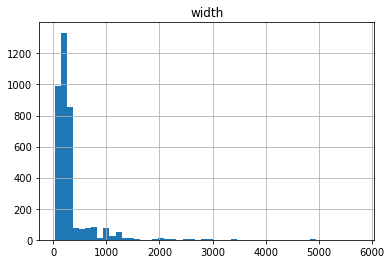

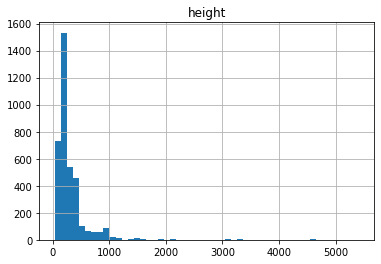

In [10]:
df.hist('width', bins=50), df.hist('height', bins=50)

In [11]:
dimension_matrix = []
for i in range(len(wo_mask_files)):
    image = Image.open(os.path.join(wo_mask_dir,wo_mask_files[i]))
    width, height = image.size
    dimension_matrix.append([width, height])
df = pd.DataFrame(dimension_matrix, columns=['width', 'height'])

(array([[<AxesSubplot:title={'center':'width'}>]], dtype=object),
 array([[<AxesSubplot:title={'center':'height'}>]], dtype=object))

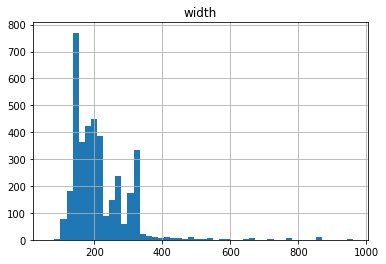

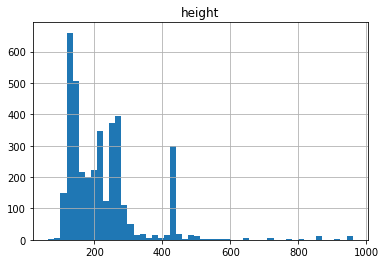

In [12]:
df.hist('width', bins=50), df.hist('height', bins=50)

In [13]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

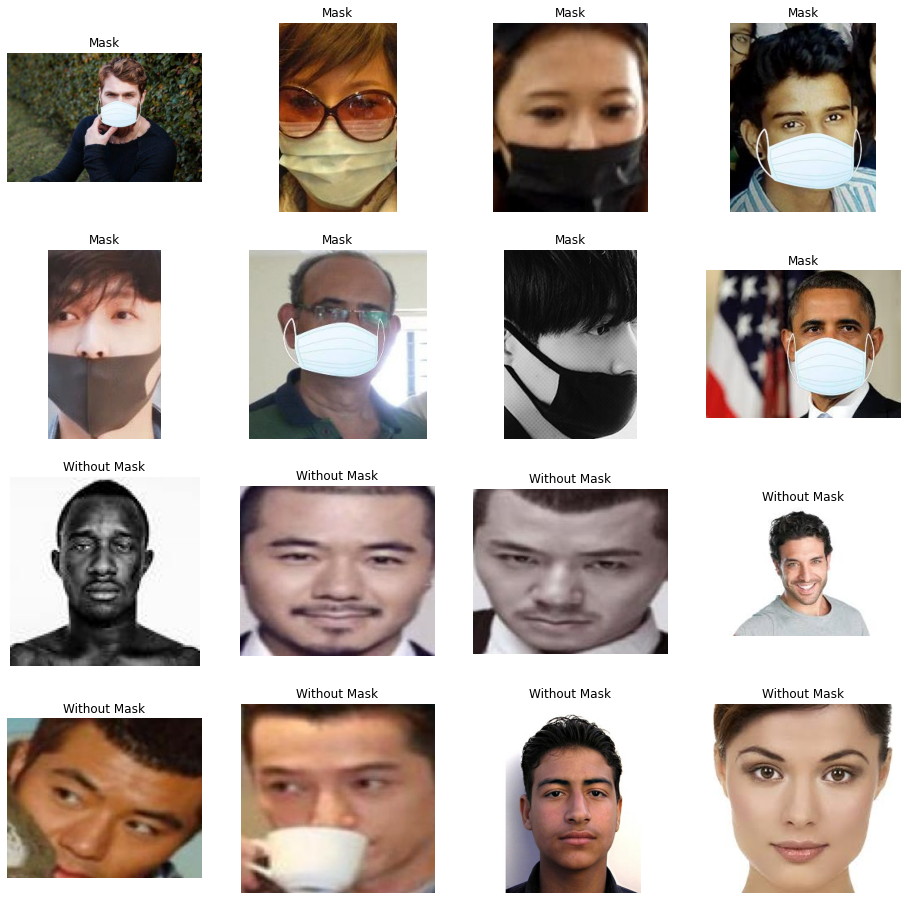

In [14]:

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_mask_pix = [os.path.join(mask_dir, fname) 
                for fname in mask_files[pic_index-8:pic_index]]
next_wo_mask_pix = [os.path.join(wo_mask_dir, fname) 
                for fname in wo_mask_files[pic_index-8:pic_index]]

for i, img_path in enumerate(next_mask_pix+next_wo_mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = Image.open(img_path)
  plt.imshow(img)
  if i < 8:
    plt.title("Mask")
  else:
    plt.title("Without Mask")
plt.show()

In [4]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('with mask') and 1 for the other ('without mask')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range=[0.4,1.5],
                                   validation_split=0.2) # 20% split and it is not random

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # created another generator for validation without augmentation

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle=True,
        subset='training') #set as training data

validation_generator = val_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle=False,
        subset='validation') #set as validation data

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [7]:
logdir = "./logs/cifar/" 

# Define the basic TensorBoard callback for logging the scalars etc
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [8]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=20,
      initial_epoch=0,
      callbacks=[tensorboard_callback],
      verbose=1)

Epoch 1/20
19/94 [=====>........................] - ETA: 1:52 - loss: 0.7112 - accuracy: 0.5806

c:\Users\Bao\Desktop\comp-vision-py\project_env\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 [==============================] - 165s 2s/step - loss: 0.5641 - accuracy: 0.7212 - val_loss: 0.2973 - val_accuracy: 0.8825
Epoch 2/20
94/94 [==============================] - 150s 2s/step - loss: 0.4365 - accuracy: 0.8120 - val_loss: 0.2457 - val_accuracy: 0.9198
Epoch 3/20
94/94 [==============================] - 165s 2s/step - loss: 0.3665 - accuracy: 0.8448 - val_loss: 0.1627 - val_accuracy: 0.9518
Epoch 4/20
94/94 [==============================] - 156s 2s/step - loss: 0.3413 - accuracy: 0.8610 - val_loss: 0.2011 - val_accuracy: 0.9321
Epoch 5/20
94/94 [==============================] - 160s 2s/step - loss: 0.3164 - accuracy: 0.8716 - val_loss: 0.1335 - val_accuracy: 0.9558
Epoch 6/20
94/94 [==============================] - 153s 2s/step - loss: 0.2915 - accuracy: 0.8844 - val_loss: 0.1385 - val_accuracy: 0.9477
Epoch 7/20
94/94 [==============================] - 155s 2s/step - loss: 0.2801 - accuracy: 0.8881 - val_loss: 0.1777 - val_accuracy: 0.9307
Epoch 8/20
94/94 [======

In [9]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [10]:
# Start TensorBoard.

%tensorboard --logdir=./logs/ --load_fast=false

Reusing TensorBoard on port 6006 (pid 7420), started 6 days, 20:41:37 ago. (Use '!kill 7420' to kill it.)

In [12]:
model.save("Mask_detection_model.h5")

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range=[0.4,1.5],
                                   validation_split=0.2) # 20% split and it is not random

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # created another generator for validation without augmentation

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle=True,
        subset='training') #set as training data

validation_generator = val_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle=False,
        subset='validation') #set as validation data

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [26]:
logdir = "./logs_aug/cifar/" 

# Define the basic TensorBoard callback for logging the scalars etc
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [27]:
# continued training
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=20,
      initial_epoch=0,
      callbacks=[tensorboard_callback],
      verbose=1)

Epoch 1/20
47/47 [==============================] - 162s 3s/step - loss: 0.3421 - accuracy: 0.8629 - val_loss: 0.0924 - val_accuracy: 0.9652
Epoch 2/20
47/47 [==============================] - 144s 3s/step - loss: 0.2884 - accuracy: 0.8901 - val_loss: 0.0805 - val_accuracy: 0.9702
Epoch 3/20
47/47 [==============================] - 144s 3s/step - loss: 0.2678 - accuracy: 0.8977 - val_loss: 0.0879 - val_accuracy: 0.9688
Epoch 4/20
47/47 [==============================] - 143s 3s/step - loss: 0.2416 - accuracy: 0.9052 - val_loss: 0.1100 - val_accuracy: 0.9688
Epoch 5/20
47/47 [==============================] - 142s 3s/step - loss: 0.2250 - accuracy: 0.9109 - val_loss: 0.0665 - val_accuracy: 0.9780
Epoch 6/20
47/47 [==============================] - 146s 3s/step - loss: 0.2183 - accuracy: 0.9160 - val_loss: 0.1344 - val_accuracy: 0.9496
Epoch 7/20
47/47 [==============================] - 147s 3s/step - loss: 0.2101 - accuracy: 0.9239 - val_loss: 0.1331 - val_accuracy: 0.9425
Epoch 8/20
47

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
# Start TensorBoard.

%tensorboard --logdir=./logs/ --load_fast=false

In [13]:
# def build_model(hp):  
#   model = keras.Sequential([
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
#         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
#         activation='relu',
#         input_shape=(224,224,3)
#     ),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
#         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
#         activation='relu',
#     ),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
#         kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
#         activation='relu',
#     ),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_4_filter', min_value=64, max_value=128, step=32),
#         kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
#         activation='relu',
#     ),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_5_filter', min_value=64, max_value=128, step=32),
#         kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
#         activation='relu',
#     ),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.BatchNormalization(),
#     keras.layers.Flatten(),
#     keras.layers.Dense(
#         units=hp.Int('dense_1_units', min_value=256, max_value=1024, step=128),
#         activation='relu'
#     ),
#     keras.layers.Dense(1, activation='sigmoid')
#   ])
  
#   model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
  
#   return model

In [14]:
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

In [15]:
# tuner_search=RandomSearch(build_model,
#                           objective='val_accuracy',
#                           max_trials=30,directory='output',project_name="Mask_Detection")

In [23]:
# tuner_search.search(train_generator,
#              epochs=3,
#              validation_data=(validation_generator), batch_size=batch_size)

In [24]:
# tuner_model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
# tuner_model.summary()